# Import libraries and load dataset

In [1]:
# Use pandas to load data from a CSV file
import pandas as pd
# Use numpy for numerical operations
import numpy as np
# Use matplotlib for plotting
import matplotlib.pyplot as plt
# Use seaborn for enhanced plotting
import seaborn as sns
# Use ipaddress to convert IP to binary format
import ipaddress
# Use os for file path operations
import os

# Data Preprocessing

In [ ]:
# Specify path to directory of each malware class
malware_types = ['Adware','Benign','Ransomware','Scareware','SMSmalware']

# Each directory in malware_types contains nested directories of different families of malware of that type
# Each nested directory contains multiple CSV files of different samples of that family
# Load all families of data of each type of malware into a single dataframe
malware_data = {}
for malware_type in malware_types:
    malware_df = []
    for subdir in os.listdir(malware_type):
        subdir_path = os.path.join(malware_type, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(subdir_path, file)
                    df = pd.read_csv(file_path)
                    # Drop the old 'Label' column if it exists
                    if 'Label' in df.columns:
                        df.drop(columns=['Label'], inplace=True)
                    df['Label'] = malware_type
                    malware_df.append(df)
    combined_malware_df = pd.concat(malware_df, ignore_index=True)
    malware_data[malware_type] = combined_malware_df

In [11]:
# Drop unneeded columns

# Drop IP columns
for malware_type, df in malware_data.items():
    # Drop columns that are not needed for analysis if they exist
    df.drop(columns=['Flow ID', ' Source IP', ' Destination IP', ' Timestamp'], inplace=True, errors='ignore')

    # Update the malware_data dictionary with the cleaned dataframe
    malware_data[malware_type] = df

# Go through the columns and rename them without whitespace
for malware_type, df in malware_data.items():
    # Rename columns to remove whitespace
    df.columns = [col.strip() for col in df.columns]
    # Update the malware_data dictionary with the renamed dataframe
    malware_data[malware_type] = df

In [12]:
# Print the first sample for each malware type
for malware_type, df in malware_data.items():
    print(f"First sample of {malware_type}:\n{df.head()}\n")

First sample of Adware:
   Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0        54819               443         6            194                  2   
1        51023               443         6              5                  2   
2        39805               443         6         199542                  9   
3        39805               443         6            254                  2   
4          443             36040         6        2164751                  1   

   Total Backward Packets  Total Length of Fwd Packets  \
0                       0                         31.0   
1                       0                         23.0   
2                       8                       1076.0   
3                       0                         23.0   
4                       3                          0.0   

   Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                          0.0                   31.0             

In [13]:
# Print the first sample in the first malware type on attribute attribute
attribute = 'Flow Duration'
first_malware_type = malware_types[0]
first_df = malware_data[first_malware_type]
print(f"First sample of {first_malware_type} on attribute '{attribute}':\n{first_df[attribute].head()}\n")

First sample of Adware on attribute 'Flow Duration':
0        194
1          5
2     199542
3        254
4    2164751
Name: Flow Duration, dtype: int64



In [14]:
# Use bagging to create a balanced dataset with 50k samples of each class of malware
sampled_dataframes = []
num_samples = 50000

# Iterate through each malware type and sample the data
for malware_type, df in malware_data.items():
    # Sample the data with replacement to create a balanced dataset
    sampled_df = df.sample(n=num_samples, replace=True, random_state=42)
    sampled_dataframes.append(sampled_df)

In [15]:
# Save the sampled dataframes to a CSV file
output_file = 'sampled_malware_data.csv'
sampled_data = pd.concat(sampled_dataframes, ignore_index=True)
sampled_data.to_csv(output_file, index=False)

In [ ]:
# Print the first sample of each malware type in the sampled data
for malware_type in malware_types:
    print(f"First sample of {malware_type} in sampled data:\n{sampled_data[sampled_data['Label'] == malware_type].head()}\n")

In [194]:
# Load the sampled data from the CSV file and split based on the label
output_file = 'sampled_malware_data.csv'
sampled_data = pd.read_csv(output_file)
malware_types = sampled_data['Label'].unique()

# Split the data into separate dataframes for each malware type
sampled_dataframes = []
for malware_type in malware_types:
    df = sampled_data[sampled_data['Label'] == malware_type]
    sampled_dataframes.append(df)

# Concatenate the dataframes into a single dataframe
sampled_data = pd.concat(sampled_dataframes, ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_22476\1055410345.py:3: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_data = pd.read_csv(output_file)


In [ ]:
# Print the first sample of each malware type in the sampled data
for malware_type in malware_types:
    print(f"First sample of {malware_type} in sampled data:\n{sampled_data[sampled_data['Label'] == malware_type].head()}\n")

In [195]:
def train_test_split(df, split_ratio=0.8):
    # Split each malware type with a split ratio
    train_data = []
    test_data = []

    # Iterate through each malware type and split the data
    for malware_type, df in df.groupby('Label'):
        # Split the data into training and testing sets
        train_df = df.sample(frac=split_ratio, random_state=42)
        test_df = df.drop(train_df.index)

        # Append the training and testing sets to the respective lists
        train_data.append(train_df)
        test_data.append(test_df)

    # Concatenate the training and testing sets into single dataframes
    train_df = pd.concat(train_data, ignore_index=True)
    test_df = pd.concat(test_data, ignore_index=True)

    # Shuffle the training and testing sets
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Store the label column in a separate variable
    train_labels = train_df['Label']
    test_labels = test_df['Label']

    # Drop the label column from the training and testing sets
    train_df.drop(columns=['Label'], inplace=True)
    test_df.drop(columns=['Label'], inplace=True)

    # Return the training and testing sets along with their labels
    return train_df, test_df, train_labels, test_labels

In [196]:
# Generate the training and testing sets
train_df, test_df, train_labels, test_labels = train_test_split(sampled_data, split_ratio=0.8)

In [197]:
# Print the number of each malware type in the training and testing sets
print("Training set counts:\n", train_labels.value_counts())
print("Testing set counts:\n", test_labels.value_counts())

Training set counts:
 Label
Ransomware    40000
Benign        40000
SMSmalware    40000
Adware        40000
Scareware     40000
Name: count, dtype: int64
Testing set counts:
 Label
SMSmalware    10000
Adware        10000
Benign        10000
Scareware     10000
Ransomware    10000
Name: count, dtype: int64


In [198]:
# Find columns with string values
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        print(f"Column '{col}' contains strings: {train_df[col].head(3).tolist()}")

Column 'Packet Length Std' contains strings: [0.0, 0.0, 15.500000000000002]


In [199]:
# Drop columns with string values
train_df.drop(columns=['Packet Length Std'], inplace=True, errors='ignore')
test_df.drop(columns=['Packet Length Std'], inplace=True, errors='ignore')

# Dataset Visualization + Data Cleaning (Preprocessing)

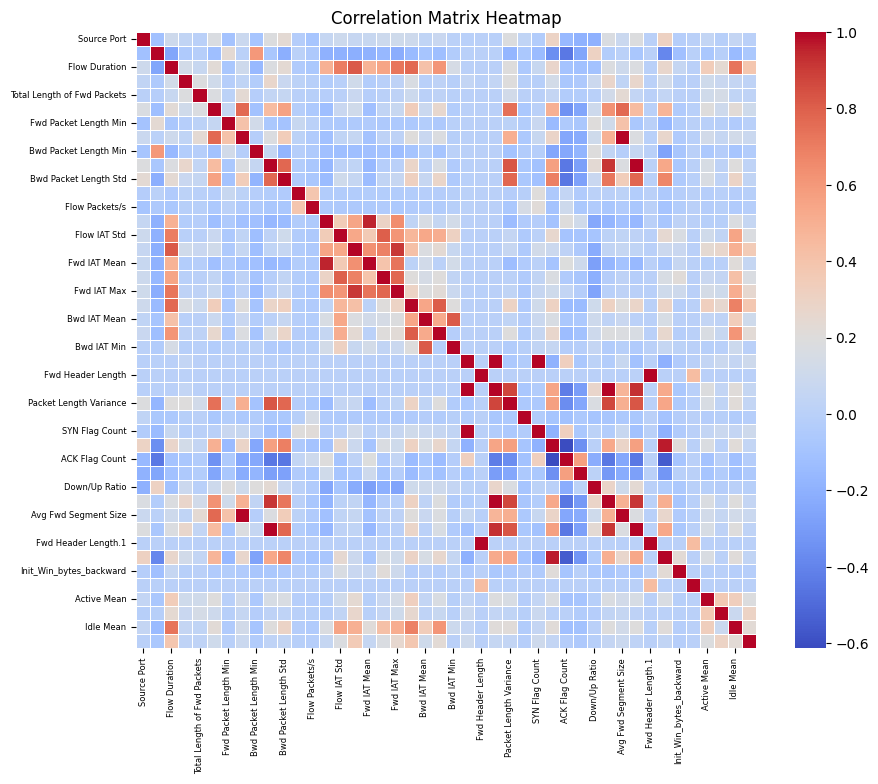

In [203]:
# Check the correlation of the features in the training set
numeric_cols = train_df.select_dtypes(include=['number']).columns
corr_matrix = train_df[numeric_cols].corr()

# Create the heatmap without annotations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# Make the tick labels smaller
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.close()

In [202]:
# Print every column in the training set
print("Training set columns:\n", train_df.columns.tolist())

Training set columns:
 ['Source Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Packet Length Mean', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Idle Mean', 'Idle Std']


In [201]:
# Select columns with high correlation or high negative correlation to reduce training time and complexity, or no correlation
drop_cols_no_corr = ['RST Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 
                     'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
drop_cols_high_corr = ['Destination Port', 'Flow IAT Max', 'Total Backward Packets', 'Total Length of Bwd Packets', 
                       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 
                       'act_data_pkt_fwd', 
                       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Bwd Packet Length Max', 'Flow IAT Min', 
                       'Fwd Packet Length Std', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Packets/s', 
                       'Bwd Packets/s', 'Bwd Header Length', 'Min Packet Length', 'Max Packet Length', 
                       'Active Max', 'Active Min', 'Idle Max', 'Idle Min']

# Drop columns from the training and testing sets if they exist
for col in drop_cols_no_corr + drop_cols_high_corr:
    if col in train_df.columns:
        train_df.drop(columns=[col], inplace=True, errors='ignore')
        test_df.drop(columns=[col], inplace=True, errors='ignore')

In [ ]:
# Save the training and testing sets to CSV files, with labels included
train_df['Label'] = train_labels
test_df['Label'] = test_labels
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

# Drop the label column from the training and testing sets for model training
train_labels = train_df['Label']
test_labels = test_df['Label']
train_df.drop(columns=['Label'], inplace=True, errors='ignore')
test_df.drop(columns=['Label'], inplace=True, errors='ignore')

In [207]:
# Load the training and testing sets from the CSV files
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Store the label column in a separate variable
train_labels = train_df['Label']
test_labels = test_df['Label']

# Drop the label column from the training and testing sets
train_df.drop(columns=['Label'], inplace=True)
test_df.drop(columns=['Label'], inplace=True)

In [209]:
# For certain models that require a sigmoid or some other activation function, scale the data to be in the range of [0, 1]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the entire training set
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

# Rebuild as DataFrames with original column names and index
train_df_scaled = pd.DataFrame(train_scaled, columns=train_df.columns, index=train_df.index)
test_df_scaled = pd.DataFrame(test_scaled, columns=test_df.columns, index=test_df.index)

In [210]:
# Print the first 5 samples of the scaled training set and the original training set
print("First 5 samples of scaled training set:\n", train_df_scaled.head())
print("First 5 samples of original training set:\n", train_df.head())

First 5 samples of scaled training set:
    Source Port  Protocol  Flow Duration  Total Fwd Packets  \
0     0.657074  0.352941       0.000472           0.000083   
1     0.713579  0.352941       0.019344           0.000083   
2     0.835732  0.352941       0.000359           0.000000   
3     0.706240  0.352941       0.087434           0.000249   
4     0.976226  1.000000       0.000009           0.000000   

   Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                     0.000000               0.000000               0.000000   
1                     0.000000               0.000000               0.000000   
2                     0.000000               0.000000               0.000000   
3                     0.000158               0.022661               0.000000   
4                     0.000014               0.002010               0.022603   

   Fwd Packet Length Mean  Bwd Packet Length Min  Bwd Packet Length Mean  ...  \
0                0.00000

# Additional Data Visualization

In [211]:
# Visualize attributes of the training set
attribute = 'Average Packet Size'

# Copy the training set to a new dataframe for visualization, including the label column
train_df_visual = train_df_scaled.copy()
train_df_visual['Label'] = train_labels

# Group values of a feature by the labels
grouped = train_df_visual.groupby('Label')[attribute].value_counts()

# Print grouped data line by line
"""for line in grouped.items():
    print(f"{line[0]}: {line[1]}")"""

# Print the first 5 most frequent features for each label type
for label in grouped.index.levels[0]:
    print(f"\nTop 5 {attribute} for label '{label}':")
    top_values = grouped[label].head(5)
    for value, count in top_values.items():
        print(f"{attribute} {value}: {count} occurances")


Top 5 Average Packet Size for label 'Adware':
Average Packet Size 0.0: 16837 occurances
Average Packet Size 0.01748448956570784: 591 occurances
Average Packet Size 0.030456852791878174: 474 occurances
Average Packet Size 0.06977681089356218: 314 occurances
Average Packet Size 0.02622673434856176: 273 occurances

Top 5 Average Packet Size for label 'Benign':
Average Packet Size 0.0: 17128 occurances
Average Packet Size 0.01748448956570784: 687 occurances
Average Packet Size 0.031020868584320363: 634 occurances
Average Packet Size 0.005828163188569281: 299 occurances
Average Packet Size 0.012972363226170333: 242 occurances

Top 5 Average Packet Size for label 'Ransomware':
Average Packet Size 0.0: 15755 occurances
Average Packet Size 0.01748448956570784: 1004 occurances
Average Packet Size 0.031020868584320363: 328 occurances
Average Packet Size 0.04060913705583757: 326 occurances
Average Packet Size 0.005828163188569281: 303 occurances

Top 5 Average Packet Size for label 'SMSmalware':

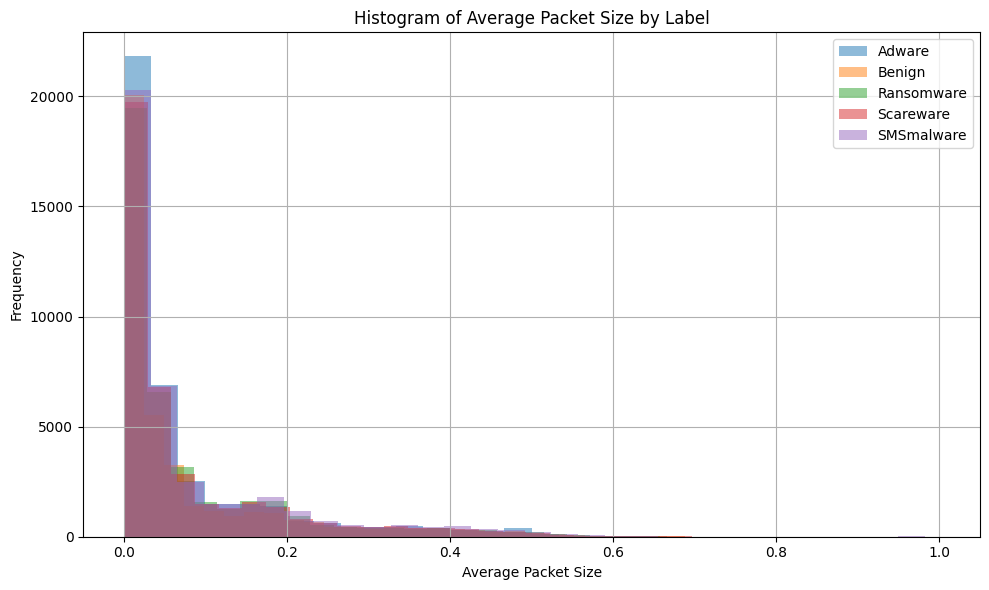

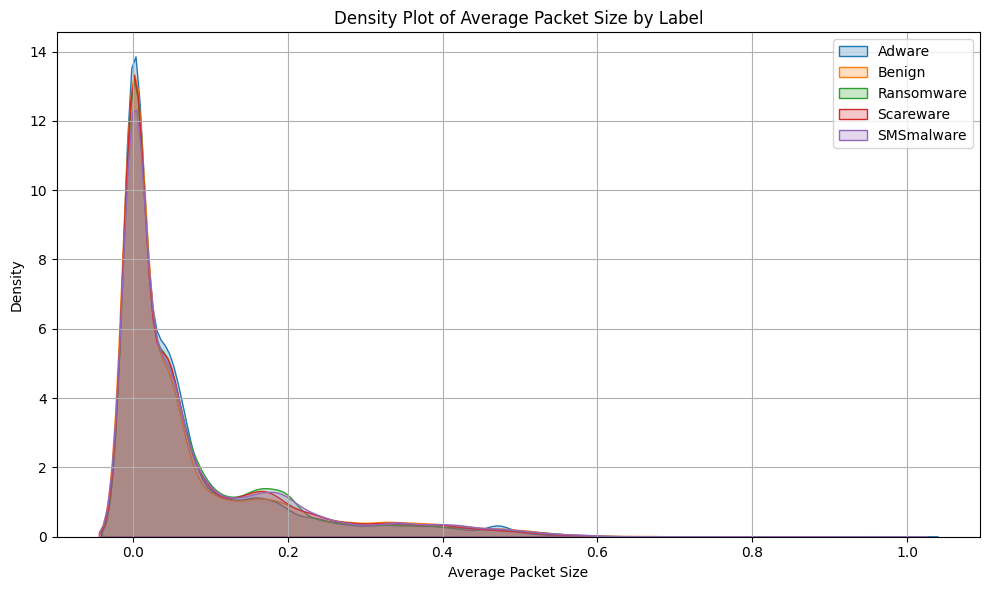

'\nWarning: \nCertain labels have more samples than others, which can skew the density plot.\nDensity graphs are not in scale with other graphs, density is relative to the number of samples for that label.\n'

In [212]:
# Visualize attributes which are more numerical in nature using matplotlib histograms
attribute = 'Average Packet Size'

# Get unique labels
labels = ['Adware', 'Benign', 'Ransomware', 'Scareware', 'SMSmalware']

# Initialize a figure for plotting
plt.figure(figsize=(10, 6))

# Plot a histogram for each label
for label in labels:
    subset = train_df_visual[train_df_visual['Label'] == label]
    plt.hist(subset[attribute], bins=30, alpha=0.5, label=label, density=False)

plt.title(f"Histogram of {attribute} by Label")
plt.xlabel(attribute)
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize density distribution of attributes using seaborn kdeplot
import seaborn as sns

plt.figure(figsize=(10, 6))

for label in labels:
    subset = train_df_visual[train_df_visual['Label'] == label]
    sns.kdeplot(subset[attribute], label=label, fill=True, common_norm=False)

plt.title(f"Density Plot of {attribute} by Label")
plt.xlabel(attribute)
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""
Warning: 
Certain labels have more samples than others, which can skew the density plot.
Density graphs are not in scale with other graphs, density is relative to the number of samples for that label.
"""

# Define + Train Models

In [ ]:
# Load the training and testing sets from the CSV files
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Store the label column in a separate variable
train_labels = train_df['Label']
test_labels = test_df['Label']

# Drop the label column from the training and testing sets
train_df.drop(columns=['Label'], inplace=True)
test_df.drop(columns=['Label'], inplace=True)